# U-net MODEL for liver segmentation from CT images

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install pydicom SimpleITK tensorboardcolab albumentations scikit-image

### Import dependecies and setup main directory to google drive directory 

In [0]:
import os
import random
import pydicom
import numpy as np
import cv2
from tqdm import tqdm
import SimpleITK as sitk
import matplotlib.pyplot as plt
import pickle
from skimage import feature
import tables
from albumentations import (
    Compose, HorizontalFlip, VerticalFlip, ShiftScaleRotate
)

In [0]:
COLUMNS, ROWS = 512, 512
main_dir = '/content/drive/My Drive/DP - Prototype'
data_dir = f'{main_dir}/data'
test_data_dir = f'{main_dir}/test_data'
patient_ids = list(filter(lambda x: x != '8', os.listdir(data_dir)))
patient_ids.sort()
patient_ids

['1', '10', '14', '16', '18', '19', '2', '21', '22', '23', '24', '5', '6']

## Open HDF file
HDF allow to read file in baches from disc during the training phase instead of reading all data to RAM at once. 

In [0]:
train_file = tables.open_file(f'{main_dir}/CT-train.h5', mode="r")
print(train_file)

/content/drive/My Drive/DP - Prototype/CT-train.h5 (File) ''
Last modif.: 'Sat May  4 15:24:13 2019'
Object Tree: 
/ (RootGroup) ''
/x (CArray(2874, 512, 512), shuffle, blosc(5)) ''
/y (CArray(2874, 512, 512), shuffle, blosc(5)) ''



In [0]:
x_train = train_file.get_node('/x')
y_train = train_file.get_node('/y')

In [0]:
def plot_slice(x, y):
  counter = 1
  if len(x.shape) > 2:
    length = x.shape[2] + 1
  else:
    length = 2
  
  figure = plt.figure(figsize=(20, 20))
  if len(x.shape) > 2 and x.shape[2] == 2:
    plt.subplot(1, length, counter) 
    plt.imshow(np.nan_to_num(x[:, :, 0]), cmap="bone")
    counter += 1
  
    plt.subplot(1, length, counter) 
    plt.imshow(np.nan_to_num(x[:, :, 1]), cmap="bone")
    counter += 1
    
  else:
    if len(y.shape) > 2:
      plt.subplot(1, length, counter) 
      plt.imshow(np.nan_to_num(x[:, :, 0]), cmap="bone")
      counter += 1
    else:
      plt.subplot(1, length, counter) 
      plt.imshow(np.nan_to_num(x), cmap="bone")
      counter += 1
    
  
  if len(y.shape) > 2:
    plt.subplot(1, length, counter)
    plt.imshow(np.nan_to_num(y[:, :, 0]), cmap="bone")
   
  else:
    plt.subplot(1, length, counter)
    plt.imshow(np.nan_to_num(y), cmap="bone")
  
  plt.show()

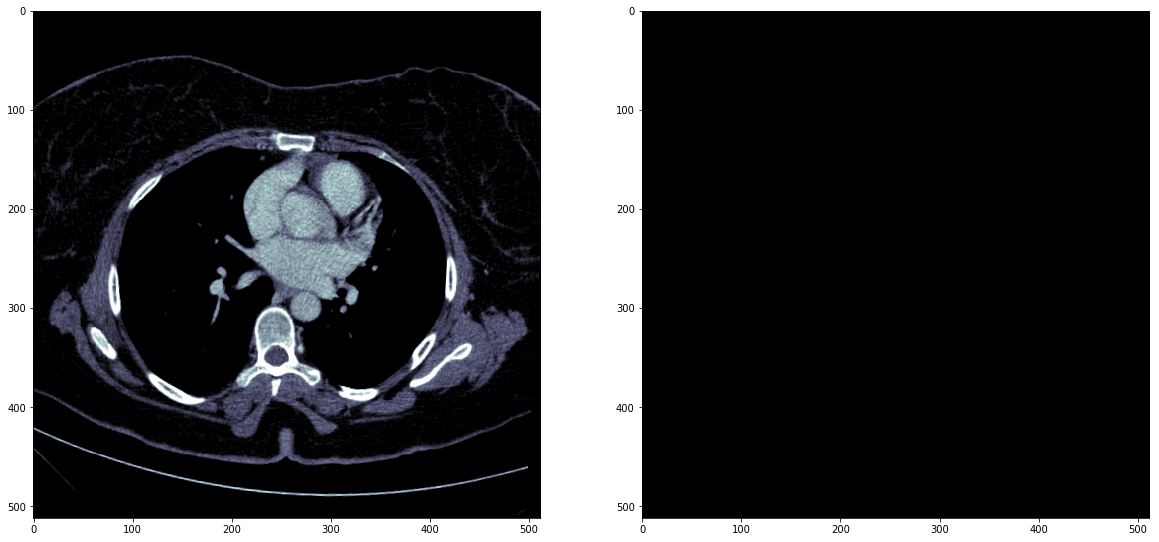

In [0]:
plot_slice(x_train[2302], y_train[2302])

### Image plots

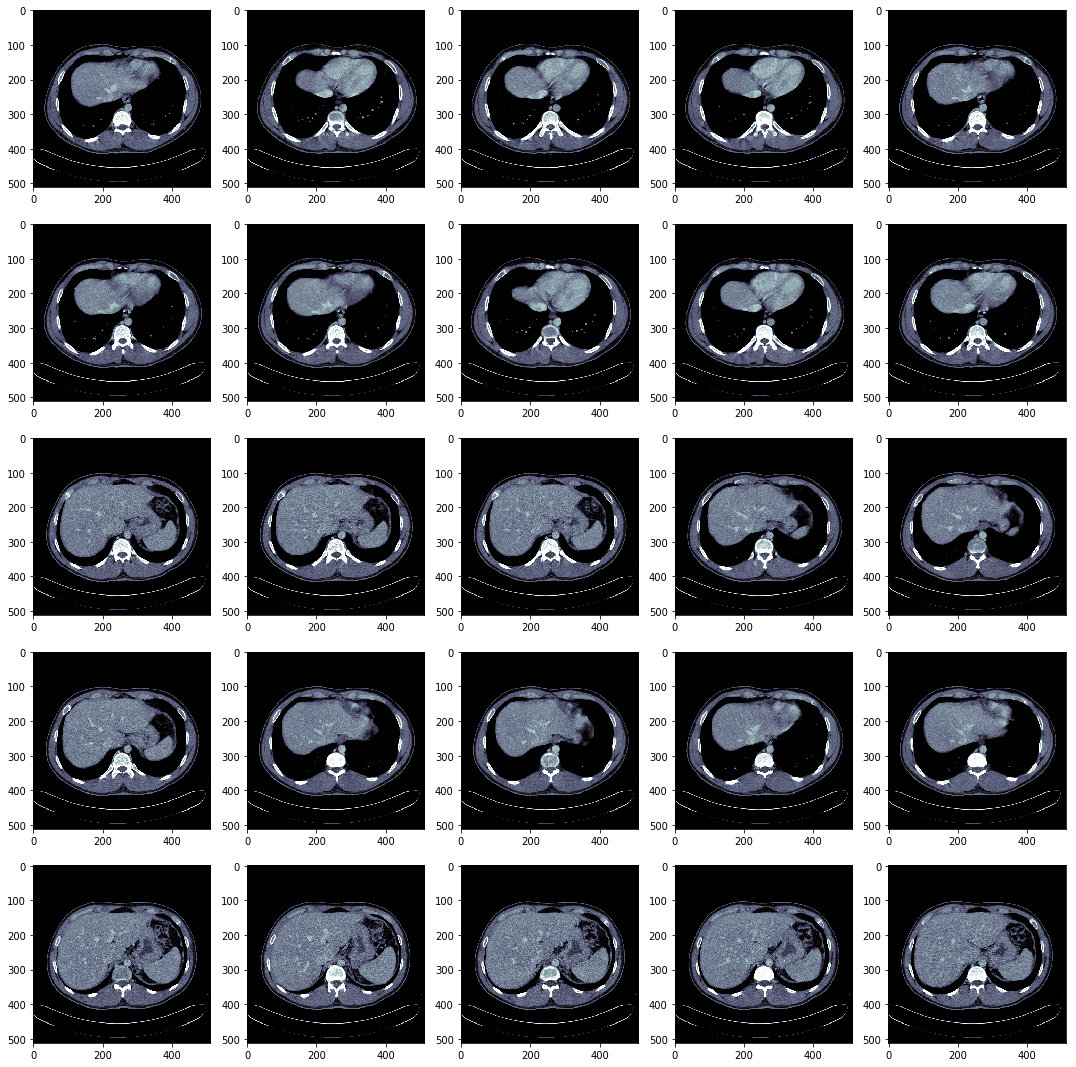

In [0]:
fig = plt.figure(figsize=(15,15))

for num in range(1,26):
    ax = fig.add_subplot(5,5,num)
    plt.imshow(x_train[num].reshape((COLUMNS, ROWS)), cmap="bone")

plt.tight_layout()
plt.show()

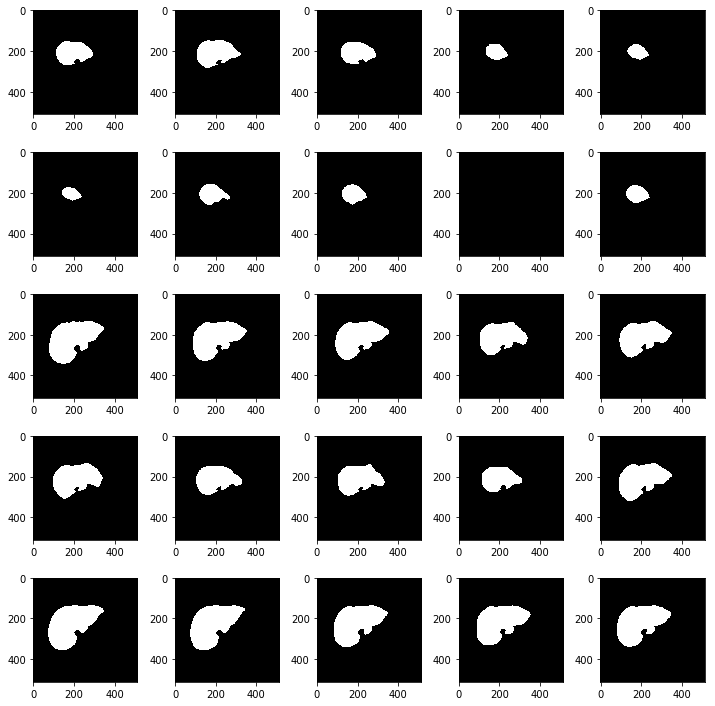

In [0]:
fig = plt.figure(figsize=(15,15))

for num in range(1,26):
    ax = fig.add_subplot(5,5,num)
    plt.imshow(y_train[num].reshape((COLUMNS, ROWS)), cmap="bone")

plt.tight_layout()
plt.show()

## Data Augmentation - Albumentations

In [0]:
TRAIN_AUGMENT = Compose([
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=8, border_mode=cv2.BORDER_CONSTANT, p=0.8),
])

## Utils
We define set of helper functions which includes metrics, generator or local binary patterns operation.

In [0]:
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as K
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from distutils.dir_util import copy_tree
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [0]:
# copy subdirectory example
fromDirectory = "./Graph"
toDirectory = f'{main_dir}/logs'


In [0]:
smooth = 0.000001
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [0]:
def round_sigmoid(x):
    res = K.sigmoid(x)
#     cond_great = K.greater_equal(res, 0.5)
#     cond_less = K.less(x, 0.5)
#     res = K.switch(cond_great, 1.0, res)
#     return K.switch(cond_less, 0.0, res)
    return K.relu()

In [0]:
def get_local_binary_pattern(x):
  res = feature.local_binary_pattern(x.copy(), 8 * 2, 2, 'uniform')
  smooth = 0.00000001
  res -= np.min(res) + smooth
  res /= np.max(res) + smooth
  return 1 - res
  

In [0]:
def generator(X_data, y_data, batch_size, indices, augmentation=None, LBP=False):
    indx = indices
    samples_per_epoch = len(indx)
    number_of_batches = samples_per_epoch / batch_size
    counter = 0

    channels = 1
    if LBP:
      channels = 2

    while 1:
        start = batch_size * counter
        stop = batch_size * (counter + 1)
        indxs = indx[start:stop]
        shape = X_data.shape
        #     print(start, stop, indxs)

        X_batch = np.zeros((batch_size, X_data.shape[1], X_data.shape[2], 1))
        y_batch = np.zeros((batch_size, y_data.shape[1], y_data.shape[2], 1))

#         print(indxs)
        
        for i, idx in enumerate(indxs):
#             print(i, idx)
            if augmentation is not None:
                x = np.nan_to_num(X_data[idx])
                y = np.nan_to_num(y_data[idx])
                aug = augmentation(image=x, mask=y)
                y_batch[i] = aug["mask"].reshape((shape[1], shape[2], 1))
                
                if LBP:
                  lbp = get_local_binary_pattern(aug["image"])
                  X_batch[i, :, :, 0] = np.nan_to_num(lbp)
#                   X_batch[i, :, :, 1] = 
                else:
                  X_batch[i, :, :] = aug["image"].reshape((shape[1], shape[2], 1))
                  
            else:
                X_batch[i, :, :, 0] = np.nan_to_num(X_data[idx])
                y_batch[i] = np.nan_to_num(y_data[idx]).reshape((shape[1], shape[2], 1))
                
                if LBP:
                  lbp = get_local_binary_pattern(np.nan_to_num(X_data[idx]))
                  X_batch[i, :, :, 0] = np.nan_to_num(lbp)

        counter += 1
        #     print('Batch X, y:', X_batch.shape, y_batch.shape)
        yield X_batch.astype(np.float64), y_batch.astype(np.float64)

        # restart counter to yeild data in the next epoch as well
        if counter >= number_of_batches:
            np.random.shuffle(indx)
            counter = 0

#### Test Activation function

In [0]:
x = np.array([[-0.0001, 0.8]])
print(K.get_value(K.sigmoid(x)))
K.get_value(round_sigmoid(x))

[[0.499975   0.68997448]]


TypeError: ignored

In [0]:
x = np.array([[0, 1]]).astype(np.float32)
y = np.array([[0, 0]]).astype(np.float32)
K.get_value(dice_coef_loss(x, y))

0.999999

#### Split to train and validation set
We are using first 16 patient from the training set as train set and remaining 4 patients as validation set. Split 2302 is the first slice of the patient in validation set. 

In [0]:
TRAIN_SIZE = x_train.shape[0]
indices = np.arange(TRAIN_SIZE)
# np.random.shuffle(indices)
split = 2302
train_ind = indices[:split]
eval_ind = indices[split:]

In [0]:
print("Train IND (example):", train_ind[:10], ', shape:', train_ind.shape)
print("Validation IND (example):", eval_ind[:10], ', shape:', eval_ind.shape)

Train IND (example): [0 1 2 3 4 5 6 7 8 9] , shape: (2302,)
Validation IND (example): [2302 2303 2304 2305 2306 2307 2308 2309 2310 2311] , shape: (572,)


## Model

Keras implementation of U-net was originaly posted [here](https://github.com/zhixuhao/unet/blob/master/model.py). Code was modified as we were experimenting with number of filters in the network.

In [0]:
def u_net(input_shape):
    inputs = Input(input_shape)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same')(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same')(pool1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same')(pool2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same')(pool3)
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same')(conv4)
    drop4 = Dropout(0.5)(conv4)

    up7 = Conv2D(128, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(drop4))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same')(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same')(conv7)

    up8 = Conv2D(64, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv8)

    up9 = Conv2D(32, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same')(merge9)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    model.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy", metrics=['accuracy', dice_coef])
    
#     model.summary()

    return model


## Train model

In [0]:
tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
http://275fa6d1.ngrok.io


In [0]:
LBP = False
channels = 1

model = u_net((COLUMNS, ROWS, channels))
# model.summary()

MODEL = 'unet-REG-50-CROSSENTROPY-AUGM'

model_checkpoint = ModelCheckpoint(f'{main_dir}/models/checkpoint/{MODEL}.hdf5', monitor='val_loss', verbose=1, save_best_only=True)

epochs = 50
batch_size = 6

train_gen = generator(x_train, y_train, batch_size, train_ind, augmentation=TRAIN_AUGMENT)
eval_gen = generator(x_train, y_train, batch_size, eval_ind, augmentation=TRAIN_AUGMENT)

# model.fit_generator(x_train, y_train, batch_size=10, epochs=50, validation_data=(x_test, y_test), callbacks=[TensorBoardColabCallback(tbc), model_checkpoint])

history = model.fit_generator(
    generator=train_gen,
    epochs=epochs,
    verbose=1,
    steps_per_epoch=train_ind.shape[0] // batch_size,
    validation_data=eval_gen,
    validation_steps=eval_ind.shape[0] // batch_size,
    callbacks=[model_checkpoint])

# Save model and tensor logs
model.save(f'{main_dir}/models/{MODEL}.hdf5')

Epoch 1/50
95/95 [==============================] - 18s 192ms/step - loss: 0.4171 - acc: 0.9405 - dice_coef: 0.5179

Epoch 00001: val_loss improved from inf to 0.41713, saving model to /content/drive/My Drive/DP - Prototype/models/checkpoint/unet-REG-50-CROSSENTROPY-AUGM.hdf5
383/383 [==============================] - 242s 633ms/step - loss: 0.8464 - acc: 0.9417 - dice_coef: 0.3771 - val_loss: 0.4171 - val_acc: 0.9405 - val_dice_coef: 0.5179
Epoch 2/50
95/95 [==============================] - 18s 186ms/step - loss: 0.3657 - acc: 0.9801 - dice_coef: 0.5488

Epoch 00002: val_loss improved from 0.41713 to 0.36568, saving model to /content/drive/My Drive/DP - Prototype/models/checkpoint/unet-REG-50-CROSSENTROPY-AUGM.hdf5
383/383 [==============================] - 240s 627ms/step - loss: 0.4135 - acc: 0.9724 - dice_coef: 0.5201 - val_loss: 0.3657 - val_acc: 0.9801 - val_dice_coef: 0.5488
Epoch 3/50
95/95 [==============================] - 18s 188ms/step - loss: 0.2537 - acc: 0.9816 - dice_c

In [0]:
OPEN_MODEL = 'unet-REG-50-dice-AUGM'

### Save training history to file

In [0]:
with open(f'{main_dir}/logs/{OPEN_MODEL}.history.pkl', 'wb') as output:  # Overwrites any existing file.
        pickle.dump(history.history, output, pickle.HIGHEST_PROTOCOL)

In [0]:
with open(f'{main_dir}/logs/{OPEN_MODEL}.history.pkl', 'rb') as input:
    input_data = pickle.load(input)

In [0]:
for key, value in input_data.items():
  print(key)

In [0]:
f = open(f"{toDirectory}/model-logs.txt", "a")
f.write(f"[MODEL] Finished training of the 'unet-ext' model. Epochs: 50, Batch size: 10, ")
f.close()

## Load and Evaluate Model

In [0]:
MODEL = "unet-ext"
TRAIN_EVENT = "./Graph/training/events.out.tfevents.1555592866.87bb619566d1"
VALIDATION_EVENT = "./Graph/validation/events.out.tfevents.1555593003.87bb619566d1"

#### Plot training STATISTICS

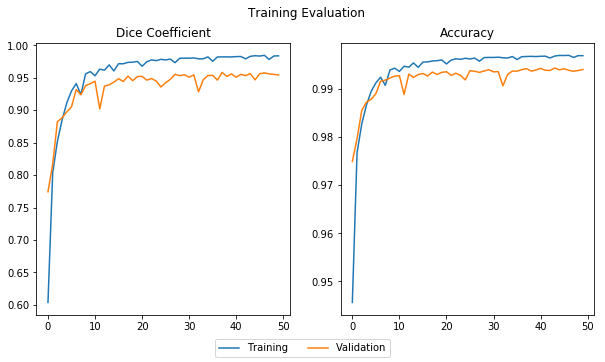

In [0]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# axs[0].plot(input_data["loss"])
# axs[0].plot(input_data["val_loss"])
# axs[0].set_title("Dice Coef. (INVERTED)")
axs[0].plot(input_data["dice_coef"])
axs[0].plot(input_data["val_dice_coef"])
axs[0].set_title("Dice Coefficient")
axs[1].plot(input_data["acc"])
axs[1].plot(input_data["val_acc"])
axs[1].set_title("Accuracy")
fig.suptitle('Training Evaluation')
plt.figlegend(["Training", "Validation"], loc = 'lower center', ncol=5, labelspacing=0. )

### Load Model - predict evaluation data

In [0]:
model = load_model(f'{main_dir}/models/checkpoint/{OPEN_MODEL}.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})
print()
print(f"Model: {OPEN_MODEL} successfuly loaded.")


Model: unet-REG-50-dice-AUGM successfuly loaded.


In [0]:
x_eval, y_eval = x_train[2302:], y_train[2302:] 
prediction = model.predict(x_eval.reshape((-1, ROWS, COLUMNS, 1), verbose=1))
print(prediction.shape)
print(x_eval.shape)
print(y_eval.shape)

(572, 512, 512, 1)
(572, 512, 512)
(572, 512, 512)


In [0]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [0]:

smooth = 0.000001
def dice_coef_np(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)


In [0]:
pred_f = np.round(prediction)
y_eval_f = y_eval

In [0]:
print('DSC', dice_coef_np(y_eval_f, pred_f))
print('Precison', precision_score(y_eval_f, pred_f))
print('Recall', recall_score(y_eval_f, pred_f))